In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
import boto3

In [2]:
labels = pd.read_csv("s3://w210-poverty-mapper/sentinel2_composite/transformed_data/metadata_with_labels_10km_radious.csv")
density = pd.read_csv("s3://w210-poverty-mapper/modeling/metadata/total_meta_data_full_updated_density.csv")

In [3]:
meta_data_labels_density = labels.merge(density, how="left", on=["filename", "zone", "center", "lat_lon_bounds", "utm_bounds", "countries", "partial_updated"])

In [4]:
meta_data_labels_density.shape

(156656, 11)

In [5]:
meta_data_labels_density.head()

,filename,zone,center,lat_lon_bounds,utm_bounds,countries,partial_updated,weighted_index,point_count,index_range,Density
0,sentinel2_composite/transformed_data/42S/341-0...,42S,"(67.78771480363916, 37.195334792066234)","[(67.77493453609193, 37.205298500604044), (67....","BoundingBox(left=391290.0, bottom=4116110.0, r...",['Tajikistan'],False,0.0,0.0,0.0,1
1,sentinel2_composite/transformed_data/42S/341-0...,42S,"(67.78803746297999, 37.175147632248574)","[(67.77526071406628, 37.18511147083712), (67.7...","BoundingBox(left=391290.0, bottom=4113870.0, r...",['Tajikistan'],False,0.0,0.0,0.0,1
2,sentinel2_composite/transformed_data/42S/341-0...,42S,"(67.7883598008825, 37.15496040109096)","[(67.77558656709091, 37.16492436967268), (67.7...","BoundingBox(left=391290.0, bottom=4111630.0, r...",['Tajikistan'],False,0.0,0.0,0.0,1
3,sentinel2_composite/transformed_data/42S/341-0...,42S,"(67.78868181768202, 37.134773098609735)","[(67.77591209550492, 37.14473719712704), (67.7...","BoundingBox(left=391290.0, bottom=4109390.0, r...",['Tajikistan'],False,0.0,0.0,0.0,1
4,sentinel2_composite/transformed_data/42S/341-0...,42S,"(67.7890035137133, 37.1145857248212)","[(67.7762372996468, 37.124549953216665), (67.7...","BoundingBox(left=391290.0, bottom=4107150.0, r...",['Tajikistan'],False,0.0,0.0,0.0,1


In [6]:
# Write merged data to s3
#meta_data_labels_density.to_csv("s3://w210-poverty-mapper/modeling/metadata/meta_data_labels_density.csv", index=False)

In [7]:
meta_data_labels_density["weighted_index"].describe()

count    140556.000000
mean         29.130352
std          30.700226
min           0.000000
25%           0.000000
50%          25.683726
75%          58.252846
max          95.092183
Name: weighted_index, dtype: float64

In [8]:
meta_data_labels_density["weighted_index"].isna().sum()

16100

In [9]:
zeros = meta_data_labels_density[meta_data_labels_density["weighted_index"] == 0]
zeros.shape[0]

67645

In [10]:
# Drop unpopulated areas and partial images
meta_data_final = meta_data_labels_density[
    (meta_data_labels_density["Density"] == 1) & 
    (meta_data_labels_density["partial_updated"] == False) & 
    (meta_data_labels_density["weighted_index"] > 0) # change to (meta_data_labels_density["weighted_index"].notna())
]

In [11]:
# Check number of rows
meta_data_final.shape

(70031, 11)

In [12]:
# Make sure only populated
meta_data_final["Density"].value_counts()

1    70031
Name: Density, dtype: int64

In [13]:
# Make sure only full images
meta_data_final["partial_updated"].value_counts()

False    70031
Name: partial_updated, dtype: int64

In [14]:
# Make sure no missing wealth index
meta_data_final["weighted_index"].isna().sum()

0

In [15]:
# Check number of remaining images per country
meta_data_final["countries"].value_counts()

['Philippines']    28135
['Bangladesh']     19258
['Nepal']          12385
['Tajikistan']      7233
['Timor Leste']     3020
Name: countries, dtype: int64

In [16]:
# Bin wealth index into 5 quantiles
meta_data_final["bin"] = pd.qcut(meta_data_final["weighted_index"], q=5, labels=False, duplicates="drop")
meta_data_final["bin_range"] = pd.qcut(meta_data_final["weighted_index"], q=5, duplicates="drop")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
# Check bins and ranges
#meta_data_final.head(50)
#meta_data_final.tail(50)

In [18]:
# Get overall bin value counts
meta_data_final["bin"].value_counts()

1    14032
0    14007
4    14006
2    13995
3    13991
Name: bin, dtype: int64

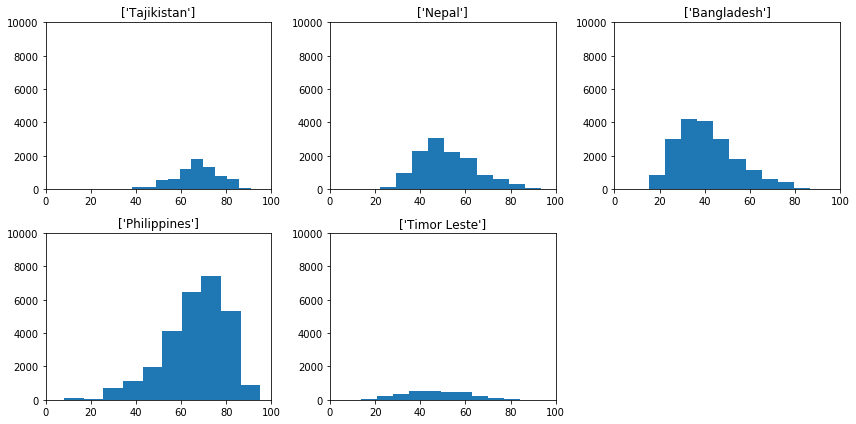

In [19]:
# Plot histograms wealth index by country
fig = plt.figure(figsize=(12,6))

country_list = [c for c in meta_data_final["countries"].unique()]

for country, num in zip(country_list, range(1,6)):
    ax = fig.add_subplot(2,3,num)
    ax.hist(meta_data_final["weighted_index"][meta_data_final["countries"] == country])
    ax.set_title(country)
    ax.set_ylim([0, 10000])
    ax.set_xlim([0, 100])

plt.tight_layout()
plt.show()

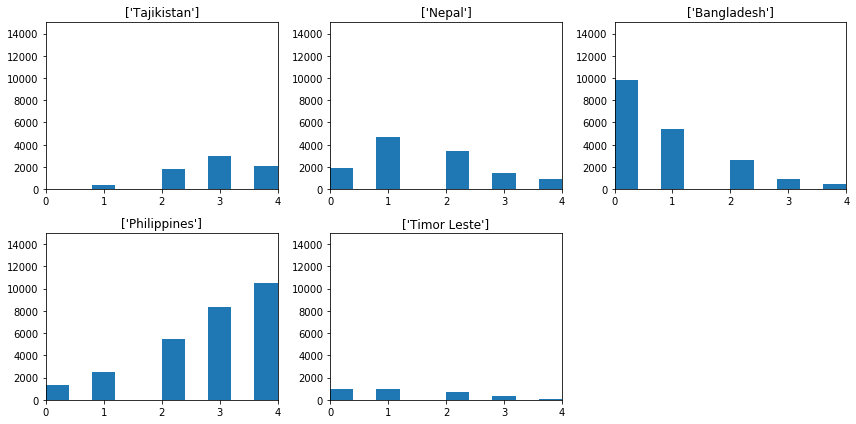

In [20]:
# Plot histograms of bins by country
fig = plt.figure(figsize=(12,6))

country_list = [c for c in meta_data_final["countries"].unique()]

for country, num in zip(country_list, range(1,6)):
    ax = fig.add_subplot(2,3,num)
    ax.hist(meta_data_final["bin"][meta_data_final["countries"] == country])
    ax.set_title(country)
    ax.set_ylim([0, 15000])
    ax.set_xlim([0, 4])
    ax.set_xticks([0,1,2,3,4]) 

plt.tight_layout()
plt.show()

In [21]:
# Write final meta data to s3
meta_data_final.to_csv("s3://w210-poverty-mapper/modeling/metadata/meta_data_final.csv", index=False)